# NOAA Coral Reef Watch's CoralTemp: Dataset Overview and Use Case Example
## CRCM-Science - Using the CoralTemp Dataset for Climate Resilient Coral Modeling (CRCM)
## EDS 220, Fall 2021

The following Jupyter notebook demonstrates key features and use case examples for the NOAA Coral Reef Watch CoralTemp dataset.

## Authors

- Alex Clippinger, Bren School of Environmental Science & Management, (alexclippinger@ucsb.edu) 
- Charles Hendrickson, Bren School of Environmental Science & Management, (c_d_h@ucsb.edu)
- Connor Flynn, Bren School of Environmental Science & Management, (connorflynn@ucsb.edu)

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Metadata](#display)

[4. Data I/O](#io)

[5. Basic Visualization](#viz)

[6. Use Case Examples](#usecases)

[7. Create Binder Environment](#binder)

[8. References](#references)

<a id='purpose'></a> 
## Purpose

This notebook was created to provide an introduction to the NOAA Coral Reef Watch CoralTemp data products, specifically the 5-km sea surface temperature dataset, although we will also introduce the sea surface temperature anomaly and degree heating week datasets. We will demonstrate the capability of these data products to analyze heat resilient coral in the face of warming sea surface temperatures.

<a id='overview'></a> 
## Dataset Description

#### Creators of the dataset

The CoralTemp data products are maintained by NOAA's Coral Reef Watch Organization (CRW). CRW was established in 2000 to address the need to enhance coral reef resilience. Since then, the organization has accurately monitored and predicted all major bleaching events since 1997. The CoralTemp dataset is the foundation of Coral Reef Watch's ability to fulfill their mission of protecting coral reefs.

#### Major characteristics

CoralTemp is a global sea surface temperature data product used primarily for coral bleaching monitoring. The dataset contains many data products based on 5 geostationary and 3 polar-orbiting satellites. These products include the main sea surface temperature data set (which is the basis for the other products), degree heating week (DHW), bleaching alert areas, coral bleaching hotspots, sea ice fraction, and sea surface temperature anomaly.

- Description of data products referenced further:
  - SST: Nighttime sea surface temperature (celcius), calibrated to 0.2 meters depth, across the entire globe.
  - SST Anomaly: A comparison of current sea surface temperature with the long term mean SST at a given location during a certain period of time
    - The temperature anomalies range from -5.0 to +5.0 degrees Celsius (°C). Data and images are updated daily
  - Degree Heating Week - The DHW shows how much heat stress (SST above the bleaching threshold) has accumulated in an area.
    - The units for DHW are "degree Celsius-weeks" (or °C-weeks), combining the intensity and duration of the oceanic heat stress into a single number.
  - Bleaching Alert Area
    - 5 levels (no stress, bleaching warning, bleaching watch, alert level 1, alert level 2)
    - Produced based on DHW
    
We will focus on the primary sea surface temperature (SST) dataset for the remainder of the notebook. The key details of the SST dataset include: 
- Spatial Resolution: 5km gridded cells.
- Spatial Coverage: The dataset has a complete spatial coverage of the ocean. 
- Temporal Resolution: 1985-04-01 to present. 

#### File format(s)

Data can be downloaded as CSV, netCDF, geotiff, and other common file formats with some unique limitations. For example, geotiff downloads can only contain a single day of data. CSV downloads on the other hand can contain multiple days of observations in a single file. The data is produced daily in near real-time, with an approximately 60 hour delay in availability from the present.

A detailed list of output formats can be found in the data product documentation here: https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html

#### Source/Archive

The data can be accessed via a REST API data access form. Here is the URL for manually querying the data: https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.html

This data source is maintained by the creator of the dataset, NOAA, indicating that this should be a reliable source of data for the foreseeable future.

#### Known issues with data quality

NOAA satellite data sets have specified processing levels ranging from 0 to 4, with 0 indicating unprocessed telemetry data as received and 4 indicating data products that are model output or results from analysis derived from multiple measurements. The CoralTemp SST product is derived from three level-4 satellite datasets:
  - NOAA/NESDIS operational near-real-time daily global 5-km geostationary-polar-orbiting (geo-polar) blended night-only SST analysis
  - NOAA/NESDIS 2002-2016 reprocessed daily global 5-km geo-polar blended night-only SST analysis
  - United Kingdom Met Office 1985-2002 daily global 5-km night-only SST reanalysis of Operational SST and Sea Ice Analysis (OSTIA)

Thus, the data is gridded and gap-filled according to NOAA’s highest processing level. Therefore, there are no significant gaps in data, spatially or temporally, and all outliers and spikes are likely reflective of real world occurrences.

Source: https://coralreefwatch.noaa.gov/product/5km/tutorial/crw05a_sst_product.php

However, there are limitations associated with using the dataset, which has a 5-km grid resolution and once-daily measurements. Although sufficient for numerous useful applications, this spatial scale may not be high enough for certain applications, such as drawing conclusions on variation in sea surface temperature within a small area such as a coral reef. Ocean sea surface temperature varies continuously across the surface, not in gridded cells, which could introduce an inherent bias in our analysis. In addition, ocean temperature varies consistently over time, while the dataset only contains a single nighttime reading per day.

<a id='display'></a> 
## Metadata

A complete list of variables and attributes, as well as their descriptions, are provided on the Data Access Form used to download CoralTemp data products. Additionally, information like the publisher name, email, and institution is provided, as well as an overall summary of the dataset, specific products, and output file formats. Information about key variables such as time, latitude, longitude, and their associated mask is extensively documented in the metadata. 

For example, 

  - Data Access Form/output format documentation: https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html
  - Detailed Metadata on all CoralTemp data products: https://coastwatch.pfeg.noaa.gov/erddap/info/NOAA_DHW/index.html

<a id='io'></a> 
## Dataset Input/Output 

The following code chunks demonstrate how to read in CoralTemp data for analysis using the REST API query.

#### Import all necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Set parameters

In [2]:
# Set parameters used in data access query
start_date = '2019-01-01T12:00:00Z'
end_date = '2019-12-31T12:00:00Z'
product_code = 'SST'
output_format = 'csv'

# Bounding box for our area of interest - Honoli'i, HI
ymax = '19.800'
ymin = '19.750'
xmin = '-155.099'
xmax = '-155.050'

#### Load CoralTemp data

In [3]:
# Query to pull data from Coral Reef Watch data products
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.'
query = base_url+output_format+'?CRW_'+product_code+'%5B('+start_date+'):1:('+end_date+')%5D%5B('+ymax+'):1:('+ymin+')%5D%5B('+xmin+'):1:('+xmax+')%5D'

# Read csv
df = pd.read_csv(query, 
                 names = ["date", "latitude", "longitude", "sst_c"], 
                 skiprows = 2)

# Remove timestamp and set date as index
df["date"] = pd.to_datetime(df["date"])

# Show preview of dataset
df.head()

,date,latitude,longitude,sst_c
0,2019-01-01 12:00:00+00:00,19.775,-155.075,24.86
1,2019-01-02 12:00:00+00:00,19.775,-155.075,24.97
2,2019-01-03 12:00:00+00:00,19.775,-155.075,24.94
3,2019-01-04 12:00:00+00:00,19.775,-155.075,24.92
4,2019-01-05 12:00:00+00:00,19.775,-155.075,24.77


<a id='viz'></a> 
## Basic Visualization

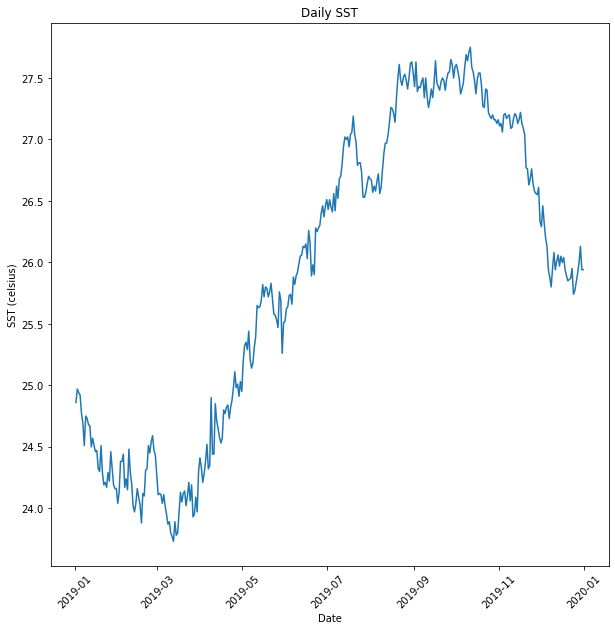

In [4]:
# Create basic time-series
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df["date"],
        df["sst_c"])
ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

<a id='usecases'></a> 
## Use Case Example - Climate Resilient Coral Modeling

#### Summary

Our team will demonstrate the ability to use the CoralTemp dataset to analyze heat resilient coral and the effects of rising sea surface temperatures on coral bleaching. Specifically, we will focus on a gridded cell containing a reef known to have heat tolerant coral, located in Honoli'i (near Hilo, Hawai'i). Coral can be heat tolerant for a variety of reasons. This analysis relies on the hypothesis that the coral of Honolii reef have the ability to adapt to heat by hosting a symbiont algae that increases their bleaching threshold by approximately 1.5 degree celsius compared to non heat tolerant coral.

As previously mentioned, the CoralTemp suite of data products are oriented towards coral reef monitoring. Primarily, the datasets are used to study and predict bleaching events and hot spots. Thus, our analysis extends on this applicability to forecasting the impact of sea surface warming on coral reefs. The target audience for this example are Coral Reef Managers and individuals interested in reef resilience. This concept can be applied to predict future reef heat tolerance in any location and guide outplanting operations to maintain reefs with longer-term heat tolerance.

Here is where the coral reef is located. We will be using SST data for the gridded cell containing this area:

![](./images/reef_location.png)

The steps of the analysis include:

**1. Load in the entire CoralTemp SST dataset (1985-Present)**

**2. Use the existing dataset to forecast SST to 2030**

**3. Calculate and visualize degree heating week**

#### Walkthrough

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime

**1. Load in the entire CoralTemp SST dataset (1985-Present)**

In [6]:
# Create empty dataframe
sst_df = pd.DataFrame()

# Append all data into single dataframe
for f in glob.glob("data/*.csv"):
    df = pd.read_csv(f,
                     usecols = [0,3],
                     names = ["date", "sst_c"], 
                     skiprows = 2)
    sst_df = sst_df.append(df, ignore_index = True)

# Change date column from str to datetime and make it the index
sst_df['date'] = pd.to_datetime(sst_df['date'])
sst_df = sst_df.set_index(['date'])

sst_df.tail()

,sst_c
date,
2021-11-05 12:00:00+00:00,25.77
2021-11-06 12:00:00+00:00,25.79
2021-11-07 12:00:00+00:00,25.67
2021-11-08 12:00:00+00:00,25.57
2021-11-09 12:00:00+00:00,25.75


**2. Use the existing dataset to forecast SST to 2030**

In [7]:
# Create "training" dataset - in this simple example, we are just using the year prior
sst_df_training = sst_df['2015-01-01 12:00:00+00:00':'2015-12-31 12:00:00+00:00']

# Create empty dataframe
sst_df_forecast = pd.DataFrame(columns = ['date', 'sst_c'])

# Add date range to date column
sst_df_forecast['date'] = pd.date_range(start = '2021-11-10 12:00:00+00:00', end = '2030-11-09 12:00:00+00:00')

# change date column from str to datetime and make it the index
sst_df_forecast['date'] = pd.to_datetime(sst_df_forecast['date'])
sst_df_forecast = sst_df_forecast.set_index(['date'])

# remove leap days
sst_df_forecast = sst_df_forecast[~((sst_df_forecast.index.month == 2) & (sst_df_forecast.index.day == 29))]

# Get list of years to be forecast
forecasted_years = sst_df_forecast.index.year.unique().to_numpy()[:-1]

# Iterate through years and apply basic yearly increase in SST
for year in forecasted_years:
    year_index = np.where(forecasted_years == year)[0][0]
    yearly_sst_increase = 0.2
    sst_df_forecast[str(year)+'-11-10 12:00:00+00:00':str(year+1)+'-11-09 12:00:00+00:00'] = sst_df_training + (year_index*yearly_sst_increase)
    
sst_df_forecast.head()

,sst_c
date,
2021-11-10 12:00:00+00:00,24.7
2021-11-11 12:00:00+00:00,24.71
2021-11-12 12:00:00+00:00,24.83
2021-11-13 12:00:00+00:00,24.63
2021-11-14 12:00:00+00:00,24.44


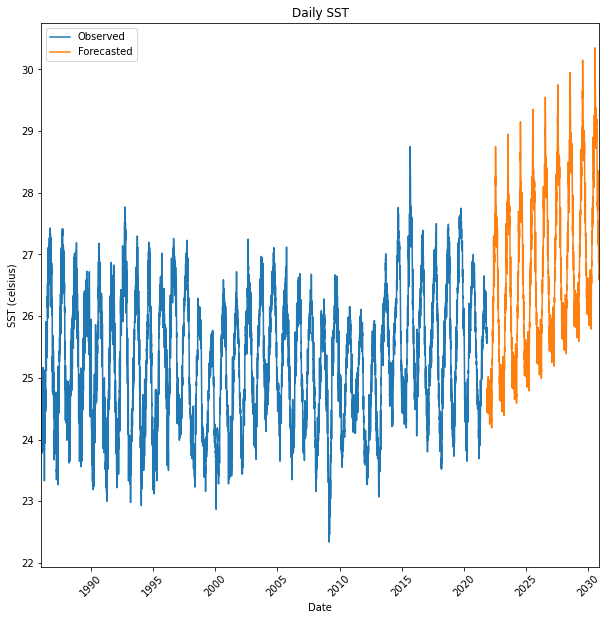

In [8]:
## Create time-series of forecasted SST values
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(sst_df.index,
        sst_df["sst_c"],
        label = "Observed")

ax.plot(sst_df_forecast.index,
        sst_df_forecast["sst_c"],
        label = "Forecasted")

ax.legend()

ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")

ax.set_xlim(left = datetime.date(1986, 1, 1), right = datetime.date(2030, 11, 9))

plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

**3. Calculate bleaching thresholds and visualize degree heating week**

First, we need to calculate our bleaching thresholds. This threshold was identified by scientists in the 1980s, who found that corals experience stress if water reaches 1°C warmer than the highest expected annual temperature (Glynn and D'Croz, 1990). Thus, the **bleaching threshold** is defined as **1°C warmer than the max monthly mean temperature**. To calculate the long term mean SST for any location, a "linear regression", "recentering" of the data, and linear interpolation is required (see here for more info: https://coralreefwatch.noaa.gov/product/5km/tutorial/crw07a_ssta_product.php).

Thankfully, the long-term means can be derived from the SST and SST anomaly data product. The SST anomaly is the difference of SST compared to the daily long term mean SST. In the code below, **we use SST and SST anomaly data for 2019 to find the long term means**, which allow us to calculate the bleaching threshold for our specific reef location

In [9]:
# Load SST data for 2019
df = sst_df['2019-01-01T12:00:00Z':'2019-12-31T12:00:00Z']
df = df.reset_index()

# Set parameters used in REST API query
start_date = '2019-01-01T12:00:00Z'
end_date = '2019-12-31T12:00:00Z'
product_code = 'SSTANOMALY'
output_format = 'csv'

ymax = '19.800'
ymin = '19.750'
xmin = '-155.099'
xmax = '-155.050'

# Query to pull data from Coral Reef Watch data products
query = r'https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.'+output_format+'?CRW_'+product_code+'%5B('+start_date+'):1:('+end_date+')%5D%5B('+ymax+'):1:('+ymin+')%5D%5B('+xmin+'):1:('+xmax+')%5D'

# Read csv
df_anomaly = pd.read_csv(query, 
                         usecols = [0,3],
                         names = ["date", "sst_anomaly"], 
                         skiprows = 2)

# Remove timestamp
df_anomaly["date"] = pd.to_datetime(df_anomaly["date"])

# Calculate 28 year mean based on anomaly dataset
df_anomaly["monthly_mean_sst"] = df['sst_c'] - df_anomaly['sst_anomaly']

# Find max monthly mean
df_month = df_anomaly.groupby(df_anomaly["date"].dt.strftime('%B'))['monthly_mean_sst'].mean().sort_values()

# Set bleaching thresholds
bleaching_threshold = df_month.max() + 1
bleaching_threshold_ht = bleaching_threshold + 1.5

print("Normal bleaching threshold: " + str(round(bleaching_threshold, 2)))
print("Heat tolerant bleaching threshold: " + str(round(bleaching_threshold_ht, 2)))

Normal bleaching threshold: 27.62
Heat tolerant bleaching threshold: 29.12


Next, we calculate the **degree heating week** (DHW). Here is NOAA's definition of this metric from the metadata: "The DHW value at any particular location at any particular time is the summation of the product of HotSpot values which are at least 1 deg C above the bleaching threshold SST and their durations in weeks over the most recent 12-week period."

In [10]:
## Calculate degree heating week

# Combine observed and forecasted data
heat_stress_df = pd.concat([sst_df, sst_df_forecast], axis = 0)

# Create columns showing daily heat stress
heat_stress_df["above_threshold"] = np.where(heat_stress_df['sst_c'] - bleaching_threshold <= 0, 0, heat_stress_df['sst_c'] - bleaching_threshold)
heat_stress_df["above_threshold_ht"] = np.where(heat_stress_df['sst_c'] - bleaching_threshold_ht <= 0, 0, heat_stress_df['sst_c'] - bleaching_threshold_ht)

# Calculate degree heating week (cumulative heat stress)
heat_stress_df['dhw'] = heat_stress_df['above_threshold'].rolling(min_periods=1, window=84).sum()/7
heat_stress_df['dhw_ht'] = heat_stress_df['above_threshold_ht'].rolling(min_periods=1, window=84).sum()/7

heat_stress_df

,sst_c,above_threshold,above_threshold_ht,dhw,dhw_ht
date,,,,,
1985-11-09 12:00:00+00:00,25.45,0,0,0.000000,0.000000
1985-11-10 12:00:00+00:00,25.56,0,0,0.000000,0.000000
1985-11-11 12:00:00+00:00,25.7,0,0,0.000000,0.000000
1985-11-12 12:00:00+00:00,25.87,0,0,0.000000,0.000000
1985-11-13 12:00:00+00:00,26.02,0,0,0.000000,0.000000
...,...,...,...,...,...
2030-11-05 12:00:00+00:00,26.89,0,0,7.772571,0.045143
2030-11-06 12:00:00+00:00,26.82,0,0,7.615333,0.045143
2030-11-07 12:00:00+00:00,26.65,0,0,7.410952,0.045143


Lastly, we can visualize SST and Degree Heating Week for our forecasted years.

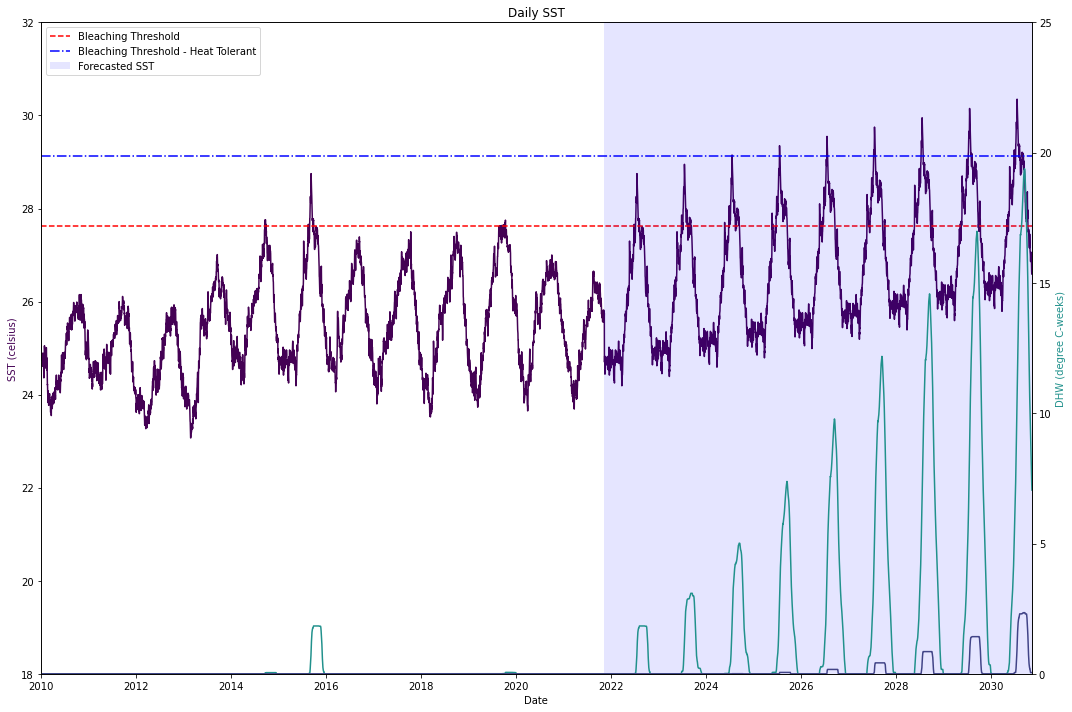

In [22]:
## SOURCE: https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

fig, ax = plt.subplots(figsize=(15,10))
    
dhw = ax.twinx()
    
ax.set_xlim(left = datetime.date(2010, 1, 1), right = datetime.date(2030, 11, 9))
ax.set_ylim(18, 32)
dhw.set_ylim(0, 25)
    
ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "SST and DHW")
dhw.set_ylabel("DHW (degree C-weeks)")

ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")

sst_plot, = ax.plot(heat_stress_df.index, 
                    heat_stress_df['sst_c'], 
                    color = plt.cm.viridis(0), 
                    label = "SST (C)")

dhw_plot, = dhw.plot(heat_stress_df.index, 
                     heat_stress_df['dhw'], 
                     color = plt.cm.viridis(0.5), 
                     label = "DHW (degree C-weeks)")

dhw_ht_plot, = dhw.plot(heat_stress_df.index, 
                        heat_stress_df['dhw_ht'], 
                        color = plt.cm.viridis(0.2), 
                        label = "Heat Tolerant DHW (degree C-weeks)")

bleaching = ax.axhline(y = bleaching_threshold, 
                       color = "red", 
                       linestyle = '--',
                       label = "Bleaching Threshold")

bleaching_ht = ax.axhline(y = bleaching_threshold_ht, 
                          color = "blue", 
                          linestyle = '-.',
                          label = "Bleaching Threshold - Heat Tolerant")

forecast = plt.axvspan(datetime.date(2021, 11, 9), datetime.date(2030, 11, 9), facecolor='b', alpha=0.1, label = "Forecasted SST")

ax.legend(handles = [bleaching, bleaching_ht, forecast], loc='upper left')

ax.yaxis.label.set_color(sst_plot.get_color())
dhw.yaxis.label.set_color(dhw_plot.get_color())

fig.tight_layout()

plt.savefig("sst_dhw.pdf")

#### Discussion of results

As we can see in the plot above, the increased heat tolerance of certain coral species drastically decreases their likelihood of bleaching and mortality.

The most obvious extension of our results would be to improve our forecasting method to use an actual time-series forecasting model, such as Seasonal Autoregressive Integrated Moving Average (SARIMA) or Double-Seasonal Holt-Winters Forecasting. Clearly, applying a linear increase in sea surface temperature to a single year of data is not an accurate representation of future change. Local sea surface temperature year to year is impacted greatly by El Nino/La Nina events and other factors. This non-linear change in SST can be seen for our observed data from 1985-Present.

Further, this analysis could be extended to look at other reefs with known major bleaching events (for example, the 2016-2017 bleaching events impacting the Great Barrier Reef) and visualizing the potential increased tolerance and impact on heat tolerant coral species. 

<a id='binder'></a> 
### Create Binder Environment

The last step is to create a Binder environment for your project, so that we don't have to spend time configuring everyone's environment each time we switch between group presentations. Instructions are below:

 - Assemble all of the data needed in your Github repo: Jupyter notebooks, a README file, and any datasets needed (these should be small, if included within the repo). Larger datasets should be stored on a separate server, and access codes included within the Jupyter notebook as discussed above. 
 
 - Create an _environment_ file: this is a text file which contains information on the packages needed in order to execute your code. The filename should be "environment.yml": an example that you can use for the proper syntax is included in this template repo. To determine which packages to include, you'll probably want to start by displaying the packages loaded in your environment: you can use the command `conda list -n [environment_name]` to get a list.
 
 More information on environment files can be found here:
 https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#

 - Create Binder. Use http://mybinder.org to create a  URL for your notebook Binder (you will need to enter your GitHub repo URL). You can also add a Launch Binder button directly to your GitHub repo, by including the following in your README.md:

```
launch with myBinder
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/<path to your repo>)
```

<a id='references'></a> 
### References

1. “NOAA Coral Reef Watch Tutorial.” Accessed November 19, 2021. https://coralreefwatch.noaa.gov/product/5km/tutorial/welcome.php.

2. Coles, Steve L., Keisha D. Bahr, Ku’ulei S. Rodgers, Stacie L. May, Ashley E. McGowan, Anita Tsang, Josh Bumgarner, and Ji Hoon Han. “Evidence of Acclimatization or Adaptation in Hawaiian Corals to Higher Ocean Temperatures.” PeerJ 6 (August 7, 2018): e5347. https://doi.org/10.7717/peerj.5347.

